https://www.kaggle.com/c/new-york-city-taxi-fare-prediction/

# Imports

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import os
from datetime import datetime as dt

In [3]:
from fastai.imports import *
from fastai.structured import *

from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor
from IPython.display import display

from sklearn import metrics

In [4]:
PATH = 'data/nyc-taxi/'

# Setup training data

The entire dataset has about 55,423,857 rows

In [5]:
types = {'fare_amount': 'float32',
         'pickup_longitude': 'float32',
         'pickup_latitude': 'float32',
         'dropoff_longitude': 'float32',
         'dropoff_latitude': 'float32',
         'passenger_count': 'uint8'}

In [7]:
df_list = []
chunksize = 10 ** 7 #10 million row at one go
i = 0

for chunk in pd.read_csv(f'{PATH}train.csv', parse_dates=["pickup_datetime"], 
                         infer_datetime_format=True, dtype=types, chunksize=chunksize):
    i = i+1
    print(f'Chunk {i}')
    chunk.drop('key',axis='columns', inplace=True)
    df_list.append(chunk)
    
# merge all into one dataframe
train_df = pd.concat(df_list)

Chunk 1
Chunk 2
Chunk 3
Chunk 4
Chunk 5
Chunk 6


In [9]:
os.makedirs('tmp', exist_ok=True)

In [10]:
%%time
train_df.to_feather('tmp/taxi-all-raw')

Wall time: 5.96 s


In [10]:
%%time
train_df = pd.read_feather('tmp/taxi-all-raw')

Wall time: 7.36 s


# Quick EDA

In [11]:
display(train_df.head(3))
display(train_df.tail(3))

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,4.5,2009-06-15 17:26:21,-73.844315,40.721317,-73.841614,40.712276,1
1,16.9,2010-01-05 16:52:16,-74.016045,40.711304,-73.979271,40.782005,1
2,5.7,2011-08-18 00:35:00,-73.982735,40.761269,-73.991241,40.750561,2


,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
55423853,14.1,2011-04-02 22:04:24,-73.970505,40.752323,-73.960541,40.797340,1
55423854,28.9,2011-10-26 05:57:51,-73.980904,40.764629,-73.870605,40.773964,1
55423855,7.5,2014-12-12 11:33:00,-73.969719,40.797668,-73.970886,40.783314,1


TODO: sort by pickup_datetime?

In [13]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55423856 entries, 0 to 55423855
Data columns (total 7 columns):
fare_amount          float32
pickup_datetime      datetime64[ns]
pickup_longitude     float32
pickup_latitude      float32
dropoff_longitude    float32
dropoff_latitude     float32
passenger_count      uint8
dtypes: datetime64[ns](1), float32(5), uint8(1)
memory usage: 1.5 GB


In [12]:
train_df.describe() # pickup_datetime not shown? why?

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,5.542386e+07,5.542386e+07,5.542386e+07,5.542348e+07,5.542348e+07,5.542386e+07
mean,1.134503e+01,-7.250972e+01,3.991985e+01,-7.251106e+01,3.992067e+01,1.685380e+00
std,2.071083e+01,1.284888e+01,9.642353e+00,1.278220e+01,9.633346e+00,1.327664e+00
min,-3.000000e+02,-3.442060e+03,-3.492264e+03,-3.442025e+03,-3.547887e+03,0.000000e+00
25%,6.000000e+00,-7.399207e+01,4.073493e+01,-7.399140e+01,4.073403e+01,1.000000e+00
50%,8.500000e+00,-7.398180e+01,4.075265e+01,-7.398015e+01,4.075316e+01,1.000000e+00
75%,1.250000e+01,-7.396708e+01,4.076713e+01,-7.396368e+01,4.076810e+01,2.000000e+00
max,9.396336e+04,3.457626e+03,3.408790e+03,3.457622e+03,3.537133e+03,2.080000e+02


In [13]:
DataFrameSummary(train_df).summary()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,5.54239e+07,NaN,5.54239e+07,5.54239e+07,5.54235e+07,5.54235e+07,5.54239e+07
mean,11.345,NaN,-72.5097,39.9198,-72.5111,39.9207,1.68538
std,20.7108,NaN,12.8489,9.64235,12.7822,9.63335,1.32766
min,-300,NaN,-3442.06,-3492.26,-3442.02,-3547.89,0
25%,6,NaN,-73.9921,40.7349,-73.9914,40.734,1
50%,8.5,NaN,-73.9818,40.7527,-73.9801,40.7532,1
75%,12.5,NaN,-73.9671,40.7671,-73.9637,40.7681,2
max,93963.4,NaN,3457.63,3408.79,3457.62,3537.13,208
counts,55423856,55423856,55423856,55423856,55423480,55423480,55423856
uniques,9405,26173536,98330,116546,114629,134778,15


# Feature Engineering

## Add feature(s)

In [6]:
# Given a dataframe, add two new features 'abs_diff_longitude' and
# 'abs_diff_latitude' reprensenting the "Manhattan vector" from
# the pickup location to the dropoff location.
def add_travel_vector_features(df):
    df['abs_diff_longitude'] = (df.dropoff_longitude - df.pickup_longitude).abs()
    df['abs_diff_latitude'] = (df.dropoff_latitude - df.pickup_latitude).abs()

In [16]:
add_travel_vector_features(train_df)

TODO: Is this too simplified? Can be enhanced taking consideration of actual location?

## Prune missing values and outliers

...if there are not too much of them

### Handle missing data

In [17]:
train_df.isnull().sum() # Looking for NaN

fare_amount             0
pickup_datetime         0
pickup_longitude        0
pickup_latitude         0
dropoff_longitude     376
dropoff_latitude      376
passenger_count         0
abs_diff_longitude    376
abs_diff_latitude     376
dtype: int64

In [18]:
print('Old size: %d' % len(train_df))
train_df = train_df.dropna(how = 'any', axis = 'rows')
print('New size: %d' % len(train_df))

Old size: 55423856
New size: 55423480


### Handle outlier travel distances

Plot travel vector features to see its distribution.

We expect most of these values to be very small (likely between 0 and 1) since it should all be differences between GPS coordinates within one city.  For reference, one degree of latitude is about 69 miles.  However, we can see the dataset has extreme values which do not make sense.  Let's remove those values from our training set. Based on the scatterplot, it looks like we can safely exclude values above 5 (though remember the scatterplot is only showing the first 2000 rows...)

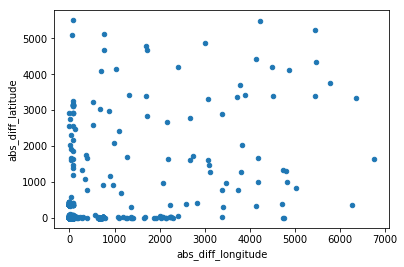

In [16]:
# warning: slow to plot
train_df.iloc[:].plot.scatter('abs_diff_longitude', 'abs_diff_latitude') 

In [19]:
print('Old size: %d' % len(train_df))
train_df = train_df[(train_df.abs_diff_longitude < 5.0) & (train_df.abs_diff_latitude < 5.0)]
print('New size: %d' % len(train_df))

Old size: 55423480
New size: 55308916


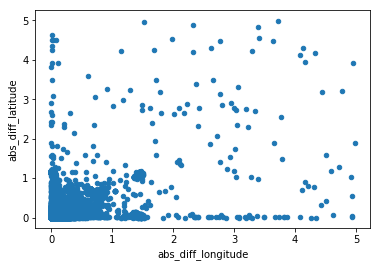

In [18]:
# warning: slow to plot
train_df.iloc[:].plot.scatter('abs_diff_longitude', 'abs_diff_latitude');

### TODO: Remove other outliers and anomalies

e.g. 208 passenger count and 93,000 fare amount!

### Tidy up and Save

In [20]:
# reset_index after removing rows, in order to be able to save to feather
train_df.reset_index(drop=True, inplace=True)

In [21]:
%%time
train_df.to_feather('tmp/taxi-all-clean1')

Wall time: 6.92 s


In [22]:
%%time
train_df = pd.read_feather('tmp/taxi-all-clean1')

Wall time: 1.48 s


## Break date time into multi columns

In [23]:
print('Before add_datepart')
train_df.head(1).T

Before add_datepart


,0
fare_amount,4.5
pickup_datetime,2009-06-15 17:26:21
pickup_longitude,-73.8443
pickup_latitude,40.7213
dropoff_longitude,-73.8416
dropoff_latitude,40.7123
passenger_count,1
abs_diff_longitude,0.00270081
abs_diff_latitude,0.00904083


In [24]:
add_datepart(train_df, 'pickup_datetime')

In [25]:
print('After add_datepart')
train_df.head(1).T

After add_datepart


,0
fare_amount,4.5
pickup_longitude,-73.8443
pickup_latitude,40.7213
dropoff_longitude,-73.8416
dropoff_latitude,40.7123
passenger_count,1
abs_diff_longitude,0.00270081
abs_diff_latitude,0.00904083
pickup_datetimeYear,2009
pickup_datetimeMonth,6


TODO: Remove some columns? e.g.

- pickup_datetimeIs_month_end	
- pickup_datetimeIs_month_start	
- pickup_datetimeIs_quarter_end	
- pickup_datetimeIs_quarter_start
- pickup_datetimeIs_year_end
- pickup_datetimeIs_year_start	
- pickup_datetimeElapsed

In [15]:
# Only use if rows are removed
# train_df.reset_index(drop=True, inplace=True)

## Save

In [28]:
%%time
train_df.to_feather('tmp/taxi-all-clean2')

Wall time: 15.7 s


# Load finalized dataframe

In [5]:
%%time
train_df = pd.read_feather('tmp/taxi-all-clean2')

Wall time: 22.6 s


In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55308916 entries, 0 to 55308915
Data columns (total 21 columns):
fare_amount                        float32
pickup_longitude                   float32
pickup_latitude                    float32
dropoff_longitude                  float32
dropoff_latitude                   float32
passenger_count                    uint8
abs_diff_longitude                 float32
abs_diff_latitude                  float32
pickup_datetimeYear                int64
pickup_datetimeMonth               int64
pickup_datetimeWeek                int64
pickup_datetimeDay                 int64
pickup_datetimeDayofweek           int64
pickup_datetimeDayofyear           int64
pickup_datetimeIs_month_end        bool
pickup_datetimeIs_month_start      bool
pickup_datetimeIs_quarter_end      bool
pickup_datetimeIs_quarter_start    bool
pickup_datetimeIs_year_end         bool
pickup_datetimeIs_year_start       bool
pickup_datetimeElapsed             int64
dtypes: bool(6),

In [8]:
# cols_to_drop=[
# 'pickup_datetimeIs_month_end',
# 'pickup_datetimeIs_month_start',
# 'pickup_datetimeIs_quarter_end',
# 'pickup_datetimeIs_quarter_start',
# 'pickup_datetimeIs_year_end',
# 'pickup_datetimeIs_year_start',
# 'pickup_datetimeElapsed']

In [9]:
# train_df.drop(cols_to_drop, axis='columns', inplace=True)

In [12]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55308916 entries, 0 to 55308915
Data columns (total 14 columns):
fare_amount                 float32
pickup_longitude            float32
pickup_latitude             float32
dropoff_longitude           float32
dropoff_latitude            float32
passenger_count             uint8
abs_diff_longitude          float32
abs_diff_latitude           float32
pickup_datetimeYear         int64
pickup_datetimeMonth        int64
pickup_datetimeWeek         int64
pickup_datetimeDay          int64
pickup_datetimeDayofweek    int64
pickup_datetimeDayofyear    int64
dtypes: float32(7), int64(6), uint8(1)
memory usage: 4.0 GB


# Split Training-Validation Data

In [6]:
n_valid = 10000  # same as Kaggle's test set size. Should we stick to it?

In [7]:
%time X, y, nas = proc_df(train_df, 'fare_amount')

Wall time: 1min 3s


In [8]:
def split_vals(a,n): return a[:n].copy(), a[n:].copy()

In [9]:
n_trn = len(X)-n_valid

X_trn, X_val = split_vals(X, n_trn)
y_trn, y_val = split_vals(y, n_trn)

In [10]:
X_trn.shape, X_val.shape, y_trn.shape, y_val.shape

((55298916, 20), (10000, 20), (55298916,), (10000,))

# Train

## Helper function to calculate evaluation metric

In [11]:
def rmse(x,y): return math.sqrt(((x-y)**2).mean())

def print_score(m):  
    
    # in scikit-learn, random forest regressor,score is the r-squared value
    trn_scr = m.score(X_trn, y_trn)
    val_scr = m.score(X_val, y_val)
    
    # RMSE is what we are more interested in
    trn_rmse = rmse(m.predict(X_trn), y_trn)
    val_rmse = rmse(m.predict(X_val), y_val)
    if hasattr(m, 'oob_score_'): oob_scr = m.oob_score_
        
    res = f"Training-Score:   {trn_scr:.5f}\tTraining-rmse:   {trn_rmse:.5f}\n"
    res += f"Validation-score: {val_scr:.5f}\tValidation-rmse: {val_rmse:.5f}"   
    if hasattr(m, 'oob_score_'): res += f"\nOOB-score:\t  {oob_scr:.5f}"
        
    print(res)

## Base Random Forest

In [25]:
# Won't work or slow because training set too big
# m = RandomForestRegressor(n_jobs=-1)
# %time m.fit(X_trn, y_trn)
# print_score(m)

## Use a subset of sample

In [12]:
subsample = 5_000_000

X_sub, y_sub, nas = proc_df(train_df, 'fare_amount', subset=subsample, na_dict=nas)
X_trn, _ = split_vals(X_sub, subsample-n_valid)
y_trn, _ = split_vals(y_sub, subsample-n_valid)

In [13]:
X_trn.shape, X_val.shape, y_trn.shape, y_val.shape 

((4990000, 20), (10000, 20), (4990000,), (10000,))

In [ ]:
m = RandomForestRegressor(n_jobs=-1)
%time m.fit(X_trn, y_trn)
print_score(m)

In [ ]:
m = RandomForestRegressor(n_estimators=20, n_jobs=-1)
%time m.fit(X_trn, y_trn)
print_score(m)

## [SKIP] Sample different random subset everytime from full dataset

Cannot work as expected. Slow!

In [25]:
X, y, nas = proc_df(train_df, 'fare_amount')
X_trn, _ = split_vals(X, n_trn)
y_trn, _ = split_vals(y, n_trn)

In [12]:
set_rf_samples(40_000) #TODO: doesnt seem to work, or physical memory problem?

In [13]:
X_trn.shape, X_val.shape, y_trn.shape, y_val.shape 

((55298916, 20), (10000, 20), (55298916,), (10000,))

In [27]:
# forest._generate_sample_indices = (lambda rs, n_samples: forest.check_random_state(rs).randint(0, n_samples, n))

In [ ]:
%%time
X_trn2 = np.array(X_trn, dtype=np.float32)

In [14]:
m = RandomForestRegressor(n_jobs=-1, min_samples_leaf=100)

In [ ]:
%prun m.fit(X_trn2, y_trn)

In [ ]:
print_score(m)

In [ ]:
m = RandomForestRegressor(n_estimators=20, n_jobs=-1)
%time m.fit(X_trn, y_trn)
print_score(m)

## Improving further via min_sample_leafs and max_features

In [ ]:
m = RandomForestRegressor(n_estimators=20, min_samples_leaf=3, max_features=0.5, n_jobs=-1)
%time m.fit(X_trn, y_trn)
print_score(m)

In [16]:
m = RandomForestRegressor(n_estimators=80, min_samples_leaf=3, max_features=0.5, n_jobs=-1)
%time m.fit(X_trn, y_trn)
print_score(m)

Wall time: 26min 33s
Training-Score:   0.39190	Training-rmse:   33.67299
Validation-score: -1.21501	Validation-rmse: 14.27476


# Predict on test data

In [17]:
# Process test data the same way we process training data
test_df = pd.read_csv(f'{PATH}test.csv', parse_dates=["pickup_datetime"], infer_datetime_format=True, dtype=types)

In [18]:
test_df_no_key = test_df.drop('key', axis='columns')
add_travel_vector_features(test_df_no_key)
add_datepart(test_df_no_key, 'pickup_datetime')

In [22]:
# cols_to_drop=[
# 'pickup_datetimeIs_month_end',
# 'pickup_datetimeIs_month_start',
# 'pickup_datetimeIs_quarter_end',
# 'pickup_datetimeIs_quarter_start',
# 'pickup_datetimeIs_year_end',
# 'pickup_datetimeIs_year_start',
# 'pickup_datetimeElapsed']

# test_df_no_key.drop(cols_to_drop, axis='columns', inplace=True)

In [19]:
test_y_predictions = m.predict(test_df_no_key)

# Submit

In [20]:
outdir = 'submissions'
os.makedirs(outdir, exist_ok=True)
    
cur_dt = dt.now().strftime("%Y%m%d_%H%M%S")
desc = 'v03_RF_' # description of submission for reference
subm_fn =  desc + cur_dt + '.csv'
subm_path = f'{outdir}/{subm_fn}'

# Write the predictions to a CSV file which we can submit to the competition.
submission = pd.DataFrame(
    {'key': test_df.key, 'fare_amount': test_y_predictions},
    columns = ['key', 'fare_amount'])
submission.to_csv(subm_path, index = False)

subm_path

'submissions/v03_RF_20180727_115750.csv'

# Save model

In [16]:
import pickle

In [22]:
model_fn_save = 'models/v03_RF_20180727_115750.pkl'

In [23]:
%time pickle.dump(m, open(model_fn_save, 'wb'))

Wall time: 3min 4s


# Load Model

In [17]:
model_fn_open = 'models/v03_RF_20180727_115750.pkl'

In [18]:
%time rf = pickle.load(open(model_fn_open, 'rb'))

Wall time: 52.5 s


In [19]:
print_score(rf)

Training-Score:   0.58797	Training-rmse:   6.75942
Validation-score: -1.21501	Validation-rmse: 14.27476
